# Exercício - Análise Exploratória

<div style="text-align:justify">
Este notebook exercita a análise exploratória no dataset <code>diabetes.csv</code>. Além da análise exploratória, vamos criar um modelo de classificação para diagnosticar as pessoas com diabetes. Como todo diagnóstico, devemos considerar a criticidade do <code>falso negativo</code>, onde um paciente não é devidamente diagnosticado e pode sofrer agravantes.

O objetivo do diagnóstico automático é reduzir custos operacionais, de modo que também é desejável um baixo <code>falso positivo</code>.
</div>

## Dependências

In [16]:
import numpy
import pandas
import seaborn
import warnings
import matplotlib.pyplot as plt

from scipy.stats import skew
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

## Carregando Dados

In [3]:
data = pandas.read_csv(
    '../../datasets/diabetes.csv',
    header=None,
    sep=',',
    names=['nr_gestacoes','glicose','pressao_sangue','grossura_pele','insulina','bmi','idx_hist','idade','classe']
)

data.head(5)

,nr_gestacoes,glicose,pressao_sangue,grossura_pele,insulina,bmi,idx_hist,idade,classe
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


## Análise de Proporção

<div style="text-align:justify">
Notamos que apenas 35% das pessoas do nosso dataset foram diagnosticadas com diabetes, de modo que a proporção das classes do nosso conjunto de dados não é balanceada. Devemos levar essa informação em conta, durante a modelagem dos dados.
</div>

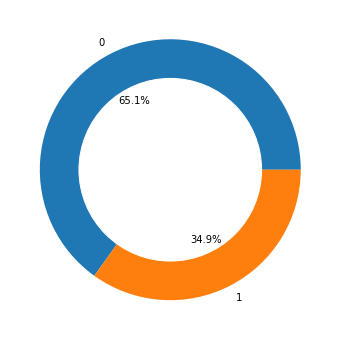

In [4]:
df = data.groupby('classe')['nr_gestacoes'].count()
sizes = df.values
label = df.index

plt.pie(sizes, labels=label, autopct='%.1f%%')
circle = plt.Circle((0, 0), 0.7, color='white')
plt.gcf().gca().add_artist(circle)
plt.show()

## Valores Faltantes

<div style="text-align:justify">
Esse é um fator importante: A média não é uma boa técnica de missing value, dado que existe grande dependência com a <code>classe objetivo</code>. Uma alternativa é usar o valor do elemento mais similar.
</div>

In [5]:
def missing_value_imputation(column):
    mean0 = data[(data[column] != 0) & (data['classe'] == 0)].groupby(column)[column].mean().values[0]
    mean1 = data[(data[column] != 0) & (data['classe'] == 1)].groupby(column)[column].mean().values[0]
    data[column][(data[column] == 0) & (data['classe'] == 0)] = mean0
    data[column][(data[column] == 0) & (data['classe'] == 1)] = mean1

missing_value_imputation('glicose')
missing_value_imputation('pressao_sangue')
missing_value_imputation('grossura_pele')
missing_value_imputation('insulina')

## Análise de Correlação - Contínuas vs Contínuas

<div style="text-align:justify">
Aqui vamos analisar a correlação entre as variáveis contínuas.
</div>

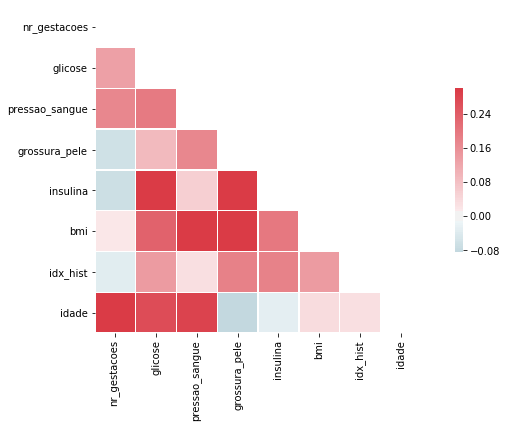

In [6]:
corr = data.loc[:, data.columns != 'classe'].corr()

mask = numpy.zeros_like(corr, dtype=numpy.bool)
mask[numpy.triu_indices_from(mask)] = True
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

## Análise de Correlação - Contínuas vs Discreta

<div style="text-align:justify">
Vamos analisar a correlação entre as variáveis <code>insulina</code>, <code>glicose</code>, <code>pressao_sangue</code> e <code>idade</code> com a variável target. Essa correlação é importante para se conhecer a importância das features em função da variável predita.
</div>

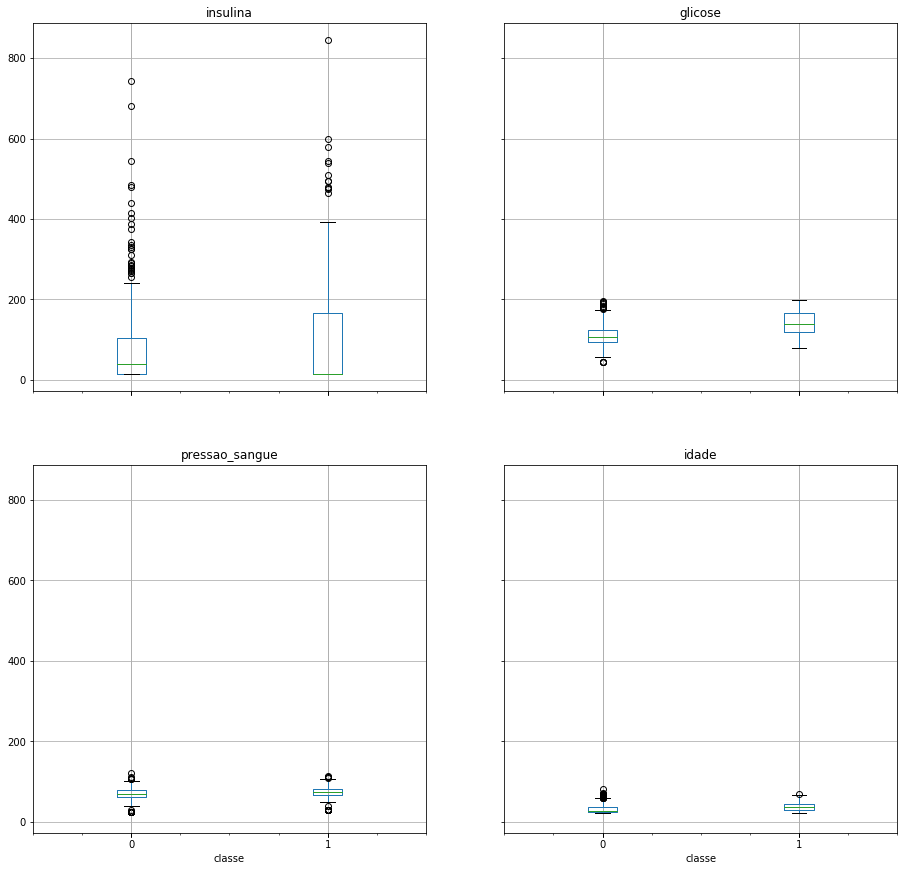

In [7]:
figure, ax = plt.subplots(figsize=(15, 15))
data.boxplot(['insulina', 'glicose', 'pressao_sangue', 'idade'], 'classe', ax)
plt.suptitle('')
plt.show()

## Análise Gráfica de Correlação - Contínuas vs Contínuas

<div style="text-align:justify">
Vejamos uma representação gráfica da correlação entre as variáveis.
</div>

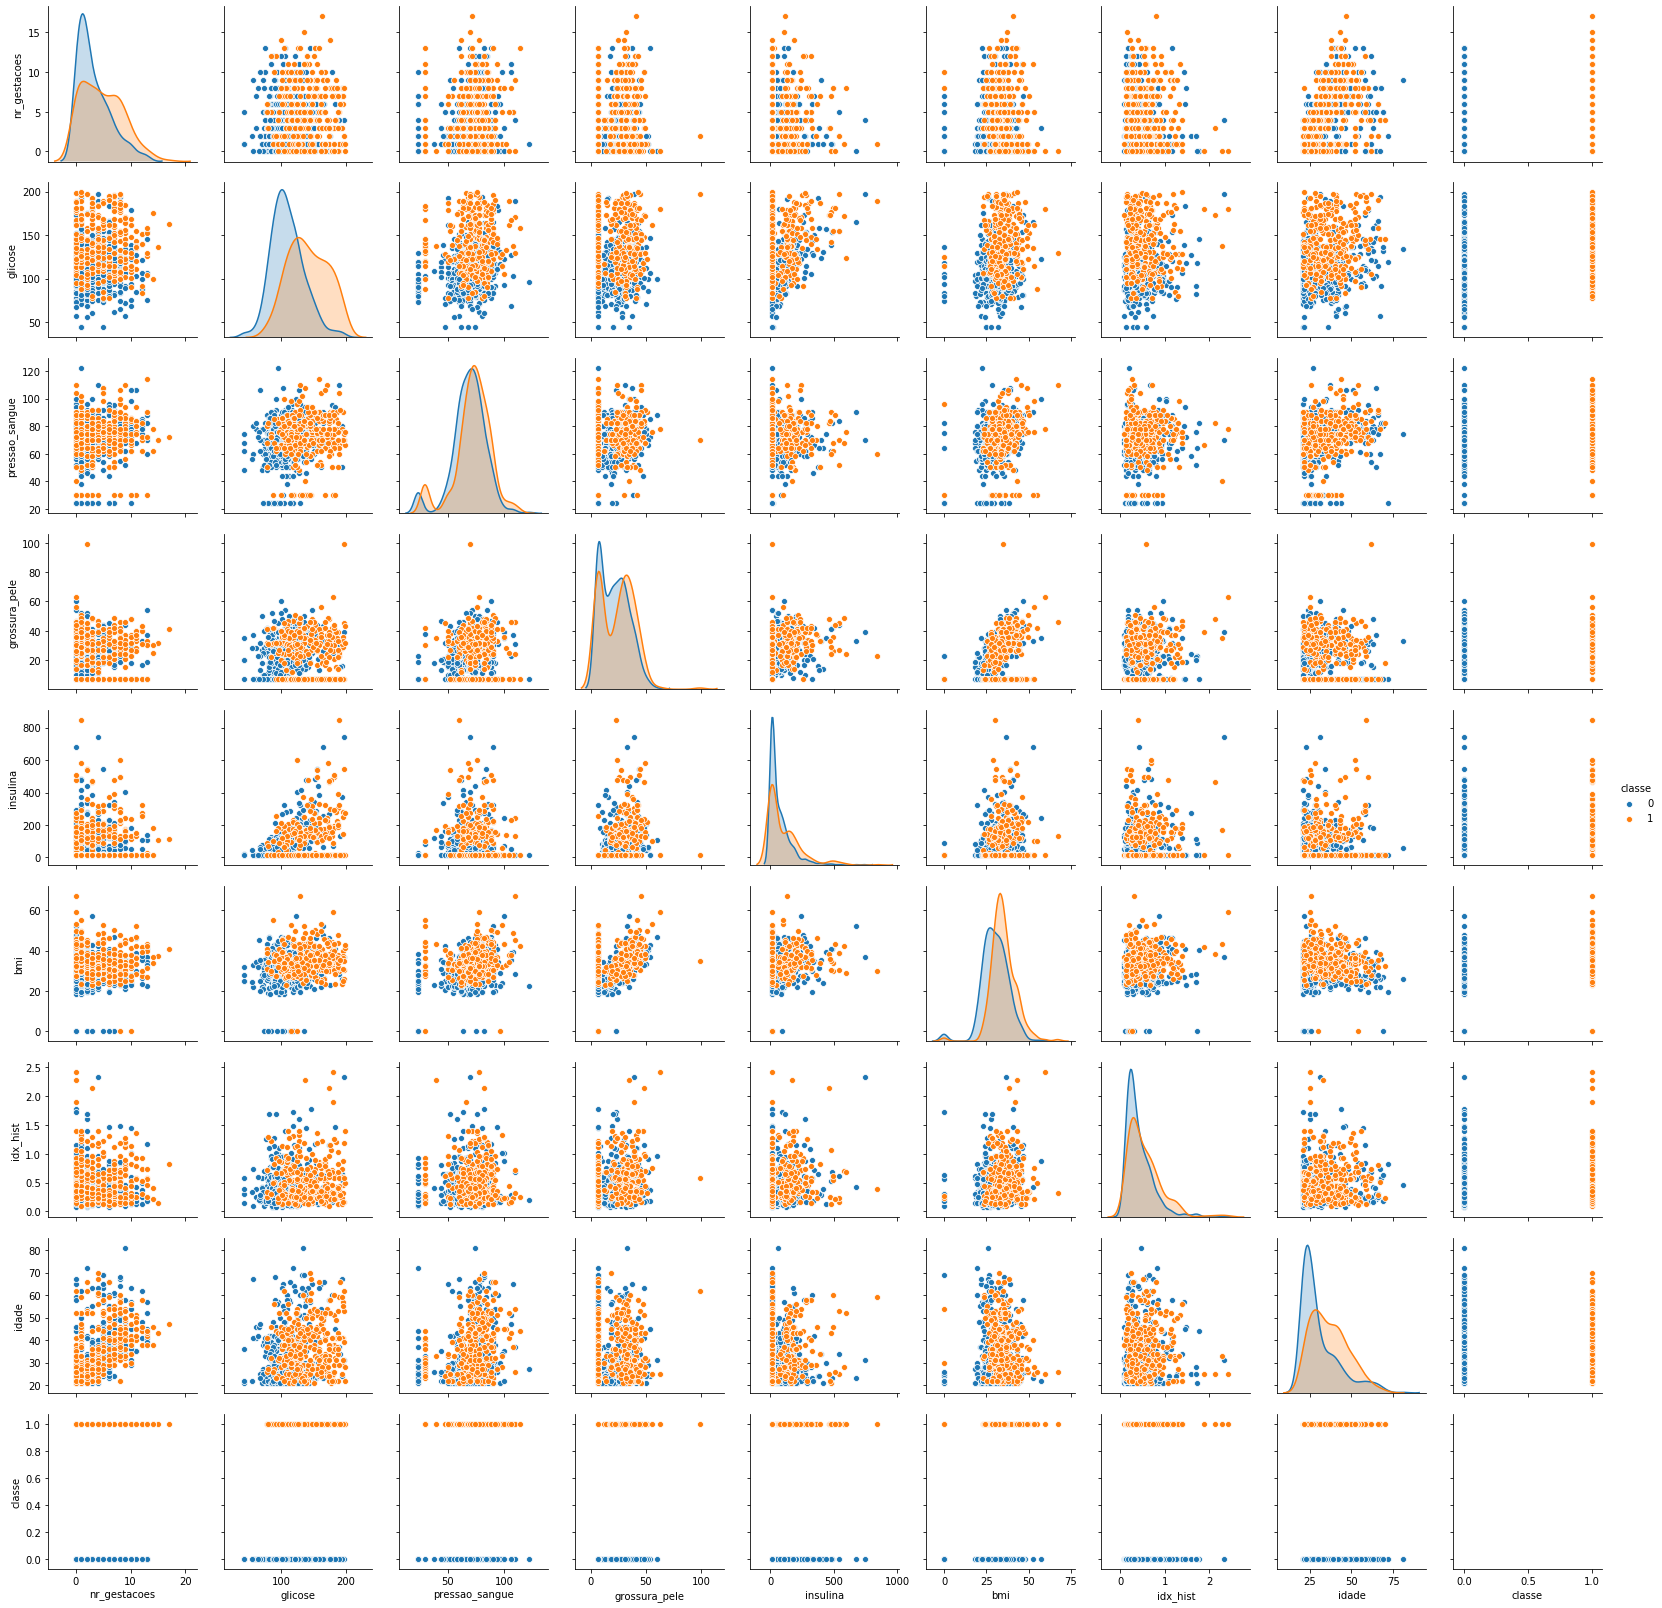

In [8]:
seaborn.pairplot(data, hue='classe')

## Selecionando Atributos e Rótulos

In [9]:
features = data.loc[:, data.columns != 'classe'].values
categories = data.classe.values

skew(features)

array([ 0.89991194,  0.47908582, -0.72864939,  0.47747003,  2.46691964,
       -0.42814328,  1.9161592 ,  1.12738926])

## Normalizando Atributos

<div style="text-align:justify">
Garantindo a normalização dos dados.
</div>

In [10]:
normalized_features = power_transform(features, method='yeo-johnson')
skew(normalized_features)

array([-4.45567499e-02, -7.88960436e-05,  8.45705989e-02, -1.02885882e-01,
        2.20164533e-01,  1.80485566e-01,  1.42043231e-01,  1.49925808e-01])

## Resolvendo Desproporcionalidade e <code>Split</code> Dados

In [11]:
under_sampler = RandomUnderSampler(random_state=42)
X_rus, y_rus = under_sampler.fit_sample(normalized_features, categories)

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42)

## Ajustando Modelo

In [12]:
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model = classifier.fit(X_train, y_train)

## Avaliando Modelo

<div style="text-align:justify">
Aqui estamos considerando a criticidade do <code>falso negativo</code>, por isso alterados o threshold do modelo.
</div>

In [13]:
y_pred = [1 if x >= 0.27 else 0 for x in model.predict_proba(X_test)[:, 1]]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        76
           1       0.84      0.98      0.90        85

    accuracy                           0.89       161
   macro avg       0.90      0.88      0.89       161
weighted avg       0.90      0.89      0.89       161



## Curva de Precisão e Revocação

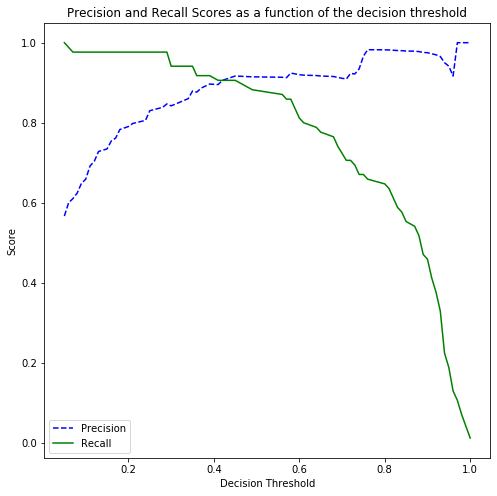

In [14]:
y_scores = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 8))
plt.title('Precision and Recall Scores as a function of the decision threshold')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend(loc='best')

## Matriz de Confusão

In [15]:
confusion_matrix(y_test, y_pred)

array([[60, 16],
       [ 2, 83]])